<a href="https://colab.research.google.com/github/ABHISHEKSHANA10/abhishek_info5731_spring2021/blob/main/In_class_exercise/In_class_exercise_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The seventh in-class-exercise (20 points in total, 3/16/2021)**

Question description: In the last in-class-exercise (exercise-06), you collected the titles of 100 articles about data science, natural language processing, and machine learning. The 100 article titles will be used as the text corpus of this exercise. Perform the following tasks:

## (1) (8 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [ ]:
pip install pyLDAvis

     |████████████████████████████████| 1.7MB 7.0MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135593 sha256=7909f2d5751fc81afe2645dc8d9f6a7d9f110b77d85e2569361fff4425a6c78a
  Stored in directory: /root/.cache/pip/wheels/74/df/b6/97234c8446a43be05c9a8687ee0db1f1b5ade5f27729187eae
Successfully built pyLDAvis


In [ ]:
# Write your code here
import re
import os
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
from google.colab import files
loaded_files = files.upload()

Saving titles.csv to titles.csv


In [ ]:
df = pd.read_csv('titles.csv')
print(df)

                                               titles
0                         Natural language processing
1             Handbook of natural language processing
2        Natural language processing: an introduction
3   Foundations of statistical natural language pr...
4   Natural language processing with Python: analy...
..                                                ...
95  Opportunities for natural language processing ...
96  Sentiment analyzer: Extracting sentiments abou...
97  Prediction and substantiation: A new approach ...
98  Natural language processing to extract medical...
99  Subsymbolic natural language processing: An in...

[100 rows x 1 columns]


In [ ]:
# Convert to list
data = df['titles'].tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Natural language processing']


In [ ]:

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['natural', 'language', 'processing']]


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['natural', 'language', 'processing']


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['natural', 'language', 'processing']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


In [ ]:
id2word[0]

'language'

In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('language', 1), ('natural', 1), ('processing', 1)]]

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -4.2607283300283

Coherence Score:  0.5203344981229494


In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2021-03-20 01:30:58--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  9.39MB/s    in 1.6s    

2021-03-20 01:30:59 (9.39 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [ ]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

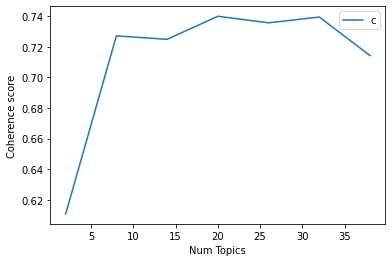

In [ ]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6108
Num Topics = 8  has Coherence Value of 0.7272
Num Topics = 14  has Coherence Value of 0.7249
Num Topics = 20  has Coherence Value of 0.74
Num Topics = 26  has Coherence Value of 0.7357
Num Topics = 32  has Coherence Value of 0.7395
Num Topics = 38  has Coherence Value of 0.7142


In [ ]:
pprint(lda_model.print_topics())

[(0,
  '0.047*"term" + 0.047*"spot" + 0.047*"discover" + 0.006*"processing" + '
  '0.006*"natural" + 0.006*"language" + 0.005*"approach" + 0.005*"learn" + '
  '0.005*"method" + 0.005*"model"'),
 (1,
  '0.189*"language" + 0.183*"natural" + 0.181*"processing" + 0.016*"system" + '
  '0.010*"use" + 0.010*"clinical" + 0.010*"learn" + 0.010*"model" + '
  '0.008*"challenge" + 0.008*"retrieval"'),
 (2,
  '0.006*"natural" + 0.006*"processing" + 0.006*"language" + 0.006*"use" + '
  '0.006*"model" + 0.006*"approach" + 0.006*"technique" + 0.006*"deep" + '
  '0.006*"base" + 0.006*"method"'),
 (3,
  '0.006*"processing" + 0.006*"natural" + 0.006*"language" + 0.006*"use" + '
  '0.006*"method" + 0.006*"model" + 0.006*"technique" + 0.006*"retrieval" + '
  '0.006*"approach" + 0.006*"base"'),
 (4,
  '0.065*"processing" + 0.065*"natural" + 0.064*"language" + 0.053*"sentiment" '
  '+ 0.042*"technique" + 0.041*"use" + 0.033*"extract" + 0.022*"give" + '
  '0.022*"topic" + 0.020*"base"'),
 (5,
  '0.076*"method

**Summarization of LDA topics**
1. Discovering the methods of approach towards Natural language processing.
2. Challenges in clinical models and system retrieval in Natural language processing.
3. Natural language processing: Methods, approach, techniques 
4. Approach on Natural Language processing and its techniques.
5. Natural language process is a technique that extracts the sentiment based on the given text. 
6. A chinese method of extracting the neural information by using Natural language processing. 
7. Processing and retrieval of neural information using Natural language processing. 
8. Deep learning technique : Retrieval of neural iinformation using natural processing. 

## (2) (8 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [ ]:
#import modules
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [ ]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [ ]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel


In [ ]:
def compute_coherence_values_lsa(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=2, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [ ]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values_lsa = compute_coherence_values_lsa(dictionary, doc_term_matrix,doc_clean,stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

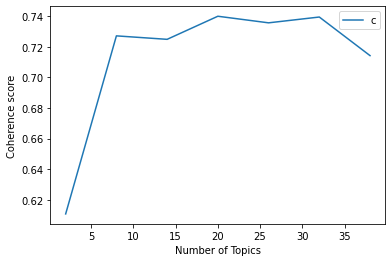

In [ ]:
start,stop,step=2,40,6
plot_graph(data_lemmatized,start,stop,step)

In [ ]:

# LSA Model
number_of_topics = 2
words = 10
model = create_gensim_lsa_model(data_lemmatized,number_of_topics,words)

[(0, '0.584*"language" + 0.574*"natural" + 0.552*"processing" + 0.056*"use" + 0.046*"system" + 0.039*"technique" + 0.033*"learn" + 0.031*"clinical" + 0.029*"sentiment" + 0.028*"learning"'), (1, '-0.585*"sentiment" + -0.470*"use" + -0.378*"technique" + -0.287*"extract" + -0.267*"topic" + -0.267*"give" + 0.076*"learn" + -0.070*"mining" + 0.061*"base" + -0.052*"accident"')]


In [ ]:
dictionary,doc_term_matrix= prepare_corpus(data_lemmatized)
model_list_lsa,coherence_values_lsa = compute_coherence_values_lsa(dictionary,doc_term_matrix,data_lemmatized,40,2,6)

In [ ]:
for m, cv in zip(x, coherence_values_lsa):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5661
Num Topics = 8  has Coherence Value of 0.4653
Num Topics = 14  has Coherence Value of 0.4653
Num Topics = 20  has Coherence Value of 0.4653
Num Topics = 26  has Coherence Value of 0.5661
Num Topics = 32  has Coherence Value of 0.5661
Num Topics = 38  has Coherence Value of 0.5661


**Summarization of LSA topics**
1. Natural Processing :Clinical Techniques involved to extract information.
2. Topic Mining and its uses for sentiment extraction with the help of given text. 


## (3) (4 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.

Latent Dirichlet Allocation(LDA):
Coherence Value = 0.7395
Number of Topics = 8

Latent Semantic Analysis(LSA):
Coherence Value = 0.5661
Number of Topics = 2

LSA is a linear algebra method whereas LDA is probabilistic.LDA is easily the most effective topic modeling technique. Initially the coherence value is of 0.6995, later after increasing up the steps we have got the number of topics also increased. Overall i can say that LDA has the highest Coherence value that means LDA has more accuracy compared to that of LSA.
The coherernt values differ for LSA and LDA.  In addition to that,
we can not expand the limit in lSA. Also LSA has low accuracy when compared to LDA. SO, I think LDA is better than LSA.